In [1]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('./data/train.csv')
sub = pd.read_csv('./data/sample_submission.csv')

# Make sure sorted by date
df = df.sort_values(by='date')
sub = sub.sort_values(by='date')

# Format date as date
df["date"] = pd.to_datetime(df["date"]).dt.date
sub["date"] = pd.to_datetime(sub["date"]).dt.date

In [2]:
df.head()

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667


In [3]:
# This is going to be a common problem to fix, but tracking is doubled 9/27/2017 and 6/12/2018

def fix_double_tracking(df, col, date_col="date"):
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] = \
    df.loc[(df[date_col] <= pd.to_datetime("2018-06-12").date()) & (df[date_col] >= pd.to_datetime("2017-09-27").date()), col] / 2
    return df


In [4]:
# sleep_hours between 9/27/2017 and 6/12/2018 is doubled and needs to be divided by 2
df = fix_double_tracking(df, "sleep_hours")

<Axes: >

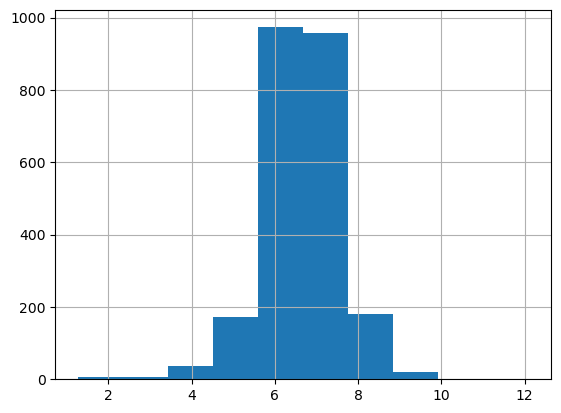

In [5]:
df.sleep_hours.hist()

In [6]:
# Fill in missing dates (for time series)

start_date = df["date"].min()
print(f"Start date: {start_date}")

end_date = df["date"].max()
print(f"End date: {end_date}")

date_range = pd.date_range(start=start_date, end=end_date, freq="D")
date_range = pd.DataFrame({"date": date_range})
date_range["date"] = date_range["date"].dt.date

df = date_range.merge(df, on="date", how="left")
print('missing days: ', df.sleep_hours.isna().sum())

Start date: 2015-02-19
End date: 2021-12-31
missing days:  154


In [7]:
# forward fill the missing values/targets
df["sleep_hours"] = df["sleep_hours"].fillna(method="ffill")

<Axes: xlabel='date', ylabel='sleep_hours'>

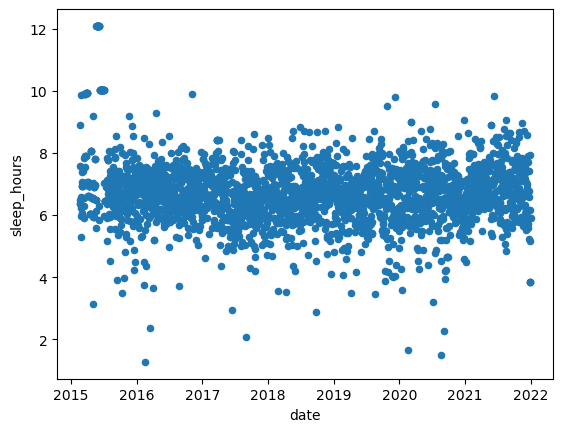

In [8]:
#plot df_sleep.sleep_hours as dots by df_sleep.date
df.plot.scatter(x='date', y='sleep_hours')

In [9]:
# Median of sleep_hours
med = df.sleep_hours.median()
print(f"Median sleep hours: {med}")


Median sleep hours: 6.683333333333334


In [10]:
sub_median = sub.copy()
sub_median["sleep_hours"] = med
sub_median.to_csv("./submissions/submission_median.csv", index=False)
sub_median.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median.csv -m "Trying just all median"
# Score : 0.67685

,date,sleep_hours
0,2022-01-01,6.683333
1,2022-01-02,6.683333
2,2022-01-03,6.683333
3,2022-01-04,6.683333
4,2022-01-05,6.683333


In [11]:
# Median of sleep_hours
mean = df.sleep_hours.mean()
print(f"Median sleep hours: {mean}")

Median sleep hours: 6.734908293460926


In [12]:
sub_mean = sub.copy()
sub_mean["sleep_hours"] = mean
sub_mean.to_csv("./submissions/submission_mean.csv", index=False)
sub_mean.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean.csv -m "Trying just all mean"
# Score: 0.67396

,date,sleep_hours
0,2022-01-01,6.734908
1,2022-01-02,6.734908
2,2022-01-03,6.734908
3,2022-01-04,6.734908
4,2022-01-05,6.734908


In [13]:
import pytz
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
### Time series Data ###

df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek # Day of the week
df["month"] = pd.to_datetime(df["date"]).dt.month # Month
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) # is_weekend

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start="2014-01-01", end="2023-12-31") 
df["is_holiday"] = df["date"].apply(lambda x: 1 if x in holidays else 0) # is_holiday
df["is_workday"] = 1-(df["is_weekend"] + df["is_holiday"]) # is_workday

In [14]:
df.head()

,date,sleep_hours,day_of_week,month,is_weekend,is_holiday,is_workday
0,2015-02-19,6.400000,3,2,0,0,1
1,2015-02-20,7.583333,4,2,0,0,1
2,2015-02-21,6.350000,5,2,1,0,0
3,2015-02-22,6.500000,6,2,1,0,0
4,2015-02-23,8.916667,0,2,0,0,1


In [15]:
# Create submissions by median by DOW
sub_median_group = sub.copy()
med = df.groupby("day_of_week")["sleep_hours"].median()
sub_median_group["day_of_week"] = pd.to_datetime(sub_median_group["date"]).dt.dayofweek
sub_median_group["sleep_hours"] = sub_median_group["day_of_week"].map(med)
sub_median_group = sub_median_group.drop("day_of_week", axis=1)
sub_median_group.to_csv("./submissions/submission_median_group.csv", index=False)
sub_median_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group.csv -m "Trying all median by DOW"
# Score: 0.67406

,date,sleep_hours
0,2022-01-01,6.950000
1,2022-01-02,6.808333
2,2022-01-03,6.533333
3,2022-01-04,6.541667
4,2022-01-05,6.566667


In [16]:
# Create submissions by median by DOW
sub_mean_group = sub.copy()
mean = df.groupby("day_of_week")["sleep_hours"].mean()
sub_mean_group["day_of_week"] = pd.to_datetime(sub_mean_group["date"]).dt.dayofweek
sub_mean_group["sleep_hours"] = sub_mean_group["day_of_week"].map(mean)
sub_mean_group = sub_mean_group.drop("day_of_week", axis=1)
sub_mean_group.to_csv("./submissions/submission_mean_group.csv", index=False)
sub_mean_group.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group.csv -m "Trying all mean by DOW"
# Score: ________________

,date,sleep_hours
0,2022-01-01,7.027723
1,2022-01-02,6.892342
2,2022-01-03,6.542714
3,2022-01-04,6.555517
4,2022-01-05,6.631844


In [17]:
# Submission by median by DOW and and is_workday
sub_median_group_workday = sub.copy()
med = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].median()
sub_median_group_workday["day_of_week"] = pd.to_datetime(sub_median_group_workday["date"]).dt.dayofweek
sub_median_group_workday["is_workday"] = 1-(sub_median_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_median_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_median_group_workday["sleep_hours"] = sub_median_group_workday[["day_of_week", "is_workday"]].apply(lambda x: med[x[0]][x[1]], axis=1)
sub_median_group_workday = sub_median_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_median_group_workday.to_csv("./submissions/submission_median_group_workday.csv", index=False)
sub_median_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_median_group_workday.csv -m "Trying all median by DOW and is_workday"
# Score: __________________

,date,sleep_hours
0,2022-01-01,6.950000
1,2022-01-02,6.808333
2,2022-01-03,6.533333
3,2022-01-04,6.541667
4,2022-01-05,6.566667


In [18]:
# Submission by mean by DOW and and is_workday
sub_mean_group_workday = sub.copy()
mean = df.groupby(["day_of_week", "is_workday"])["sleep_hours"].mean()
sub_mean_group_workday["day_of_week"] = pd.to_datetime(sub_mean_group_workday["date"]).dt.dayofweek
sub_mean_group_workday["is_workday"] = 1-(sub_mean_group_workday["day_of_week"].apply(lambda x: 1 if x >= 5 else 0) + sub_mean_group_workday["date"].apply(lambda x: 1 if x in holidays else 0))
sub_mean_group_workday["sleep_hours"] = sub_mean_group_workday[["day_of_week", "is_workday"]].apply(lambda x: mean[x[0]][x[1]], axis=1)
sub_mean_group_workday = sub_mean_group_workday.drop(["day_of_week", "is_workday"], axis=1)
sub_mean_group_workday.to_csv("./submissions/submission_mean_group_workday.csv", index=False)
sub_mean_group_workday.head()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_mean_group_workday.csv -m "Trying all mean by DOW and is_workday"
# Score: ________________

,date,sleep_hours
0,2022-01-01,7.027723
1,2022-01-02,6.892342
2,2022-01-03,6.542714
3,2022-01-04,6.555517
4,2022-01-05,6.631844


In [19]:
from glob import glob

csv_files = glob("./data/xml_export/*.csv")

# Keep what files have ~80% of the dates in the training data
unique_dates = set(df["date"])

match_threshold = 0.75 # Threshold for matching

def intersection_ratio(set1, set2):
    return len(set1 & set2) / len(set1)

matching_csvs = []
for csv_file in csv_files:
    csv_df = pd.read_csv(csv_file)  
    try: 
        csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    except:
        csv_df["date"] = pd.to_datetime(csv_df["dateComponents"]).dt.date # Some use dateComponents instead of startDate

    unique_creation_dates = set(csv_df)

    ratio = intersection_ratio(unique_dates, unique_creation_dates)

    if ratio >= match_threshold:
        matching_csvs.append(csv_file)

print("CSV files with at least 75% of the 'dates' from the original DataFrame:")
for matching_csv in matching_csvs:
    print(matching_csv)

/tmp/ipykernel_18096/3322551794.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv(csv_file)
/tmp/ipykernel_18096/3322551794.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv(csv_file)
/tmp/ipykernel_18096/3322551794.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv(csv_file)
/tmp/ipykernel_18096/3322551794.py:15: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv(csv_file)


CSV files with at least 75% of the 'dates' from the original DataFrame:


In [20]:

csv_df.loc[csv_df["date"] >= pd.to_datetime("2021-01-01").date()]

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value,date
0,Rob’s Apple Watch,9.1,"<<HKDevice: 0x2807b2940>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2022-11-25 16:55:49 -0400,2022-11-25 16:55:36 -0400,2022-11-25 16:55:36 -0400,9.8,2022-11-25
1,Rob’s Apple Watch,9.1,"<<HKDevice: 0x2807b2940>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2022-11-25 16:55:54 -0400,2022-11-25 16:55:41 -0400,2022-11-25 16:55:41 -0400,9.7,2022-11-25
2,Rob’s Apple Watch,9.1,"<<HKDevice: 0x2807b2940>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2022-11-25 16:56:00 -0400,2022-11-25 16:55:46 -0400,2022-11-25 16:55:46 -0400,9.4,2022-11-25
3,Rob’s Apple Watch,9.1,"<<HKDevice: 0x2807b2940>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2022-11-25 16:56:05 -0400,2022-11-25 16:55:52 -0400,2022-11-25 16:55:52 -0400,9.4,2022-11-25
4,Rob’s Apple Watch,9.1,"<<HKDevice: 0x2807b2940>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2022-11-25 16:56:10 -0400,2022-11-25 16:55:57 -0400,2022-11-25 16:55:57 -0400,9.7,2022-11-25
...,...,...,...,...,...,...,...,...,...,...
33377,Rob’s Apple Watch,9.3.1,"<<HKDevice: 0x2807b1f90>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2023-03-17 19:33:33 -0400,2023-03-17 19:33:20 -0400,2023-03-17 19:33:20 -0400,11.2,2023-03-17
33378,Rob’s Apple Watch,9.3.1,"<<HKDevice: 0x2807b1f90>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2023-03-17 19:33:38 -0400,2023-03-17 19:33:25 -0400,2023-03-17 19:33:25 -0400,11.3,2023-03-17
33379,Rob’s Apple Watch,9.3.1,"<<HKDevice: 0x2807b1f90>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2023-03-17 19:33:44 -0400,2023-03-17 19:33:30 -0400,2023-03-17 19:33:30 -0400,11.1,2023-03-17
33380,Rob’s Apple Watch,9.3.1,"<<HKDevice: 0x2807b1f90>, name:Apple Watch, ma...",RunningVerticalOscillation,cm,2023-03-17 19:33:49 -0400,2023-03-17 19:33:36 -0400,2023-03-17 19:33:36 -0400,9.2,2023-03-17


In [21]:
list = ["test1", "test2", "test3"]


In [22]:
# Datasets worth exploring
basal_energy_burned = pd.read_csv('./data/xml_export/BasalEnergyBurned.csv', low_memory=False)
body_mass = pd.read_csv('./data/xml_export/BodyMass.csv', low_memory=False)
flights_climbed = pd.read_csv('./data/xml_export/FlightsClimbed.csv', low_memory=False)
step_count = pd.read_csv('./data/xml_export/StepCount.csv', low_memory=False)
body_mass_index = pd.read_csv('./data/xml_export/BodyMassIndex.csv', low_memory=False)
distance_walking_running = pd.read_csv('./data/xml_export/DistanceWalkingRunning.csv', low_memory=False)


In [23]:

def parse_xml_output(path):
    # Import the csv
    csv_df = pd.read_csv(path, low_memory=False)
    base_name = os.path.basename(path).split(".")[0]
    
    # BodyMassIndex we want to avg not sum
    if base_name == "BodyMassIndex":
        agg_func = "mean"
    else:
        agg_func = "sum"
    
    # Convert startDate and endDate columns to datetime objects
    csv_df["startDate"] = pd.to_datetime(csv_df["startDate"]).dt.tz_convert ("US/Eastern")
    csv_df["endDate"] = pd.to_datetime(csv_df["endDate"]).dt.tz_convert ("US/Eastern")
    # Create date & time column
    csv_df["date"] = pd.to_datetime(csv_df["startDate"]).dt.date
    csv_df["time"] = pd.to_datetime(csv_df["startDate"]).dt.time
    
    # Group by date and perform aggregations
    csv_df = csv_df.groupby("date").agg(
        max_start_time=pd.NamedAgg(column="startDate", aggfunc="max"),
        min_start_time=pd.NamedAgg(column="startDate", aggfunc="min"),
        max_end_time=pd.NamedAgg(column="endDate", aggfunc="max"),
        min_end_time=pd.NamedAgg(column="endDate", aggfunc="min"),
        value_sum=pd.NamedAgg(column="value", aggfunc=agg_func)
    ).reset_index()
    
    # Check if the dates match between min_start_time and max_end_time
    csv_df["dates_match"] = csv_df.apply(
        lambda row: row["min_start_time"].date() == row["max_end_time"].date(), axis=1)
    csv_df = csv_df.rename(columns={"value_sum": base_name})
    
    # Assert if dates match in all rows
    # assert csv_df["dates_match"].all(), "Dates do not match in some rows"
    
    # Trigonomic Hours
    csv_df[base_name+"_mx_st_hr_sin"] = np.sin(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_st_hr_cos"] = np.cos(2 * np.pi * csv_df["max_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_sin"] = np.sin(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mn_st_hr_cos"] = np.cos(2 * np.pi * csv_df["min_start_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_sin"] = np.sin(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mx_et_hr_cos"] = np.cos(2 * np.pi * csv_df["max_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_sin"] = np.sin(2 * np.pi * csv_df["min_end_time"].dt.hour / 24)
    csv_df[base_name+"_mn_et_hr_cos"] = np.cos(2 * np.pi * csv_df["min_end_time"].dt.hour / 24) 
    
    #! HIGHLY ILLEGAL FEATURE??? (Step Count basically calculates sleep time)
    # Hours between startDate and next startDate (lag = -1)
    csv_df[base_name+"_hours_between"] = (csv_df["min_start_time"].shift(-1) - csv_df["max_start_time"]).dt.total_seconds() / 3600
    
    #Fix double tracking
    csv_df = fix_double_tracking(csv_df, base_name)
    
    # Drop unnecessary columns
    # csv_df = csv_df.drop(columns=["max_start_time", "min_start_time", "max_end_time", "min_end_time", "dates_match"])

    return csv_df

## Basal Energy Burned

In [24]:
basal_energy_burned.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Sync Solver,NaN,NaN,BasalEnergyBurned,Cal,2015-04-19 09:42:21 -0400,2012-12-23 01:00:00 -0400,2012-12-24 00:59:59 -0400,1908.0
1,Sync Solver,NaN,NaN,BasalEnergyBurned,Cal,2015-04-19 09:42:21 -0400,2013-03-12 00:00:00 -0400,2013-03-12 23:59:59 -0400,1908.0
2,Sync Solver,NaN,NaN,BasalEnergyBurned,Cal,2015-04-19 09:42:21 -0400,2015-01-01 01:00:00 -0400,2015-01-02 00:59:59 -0400,1898.0
3,Sync Solver,NaN,NaN,BasalEnergyBurned,Cal,2015-04-19 09:42:21 -0400,2014-02-17 01:00:00 -0400,2014-02-18 00:59:59 -0400,1903.0
4,Sync Solver,NaN,NaN,BasalEnergyBurned,Cal,2015-04-19 09:42:21 -0400,2012-08-20 00:00:00 -0400,2012-08-20 23:59:59 -0400,1908.0


In [25]:
# Value is the only useful feature
# Group by date and sum (set alias to basal_energy_burned)

# NOTE: Summing assumes duplicate tracking is not occuring between devices

basal_energy_burned = parse_xml_output("./data/xml_export/BasalEnergyBurned.csv")
basal_energy_burned.head()

,date,BasalEnergyBurned,BasalEnergyBurned_mx_st_hr_sin,BasalEnergyBurned_mx_st_hr_cos,BasalEnergyBurned_mn_st_hr_sin,BasalEnergyBurned_mn_st_hr_cos,BasalEnergyBurned_mx_et_hr_sin,BasalEnergyBurned_mx_et_hr_cos,BasalEnergyBurned_mn_et_hr_sin,BasalEnergyBurned_mn_et_hr_cos,BasalEnergyBurnedhours_between
0,2012-04-20,1913.0,0.0,1.0,0.0,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0
1,2012-04-21,1913.0,0.0,1.0,0.0,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0
2,2012-04-22,1913.0,0.0,1.0,0.0,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0
3,2012-04-23,1913.0,0.0,1.0,0.0,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0
4,2012-04-24,1913.0,0.0,1.0,0.0,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0


In [26]:
# Query where dates_match is false

basal_energy_burned.loc[basal_energy_burned["dates_match"] == True]

# create a sample dataframe with a datetime column
df = pd.DataFrame({'datetime': ['2012-11-05 01:23:45', '2012-11-06 05:34:56']})

# convert the datetime column to a Pandas DatetimeIndex
date_time_index = pd.DatetimeIndex(df['datetime'])

# extract the hour of day and convert it to radians
hour_of_day = date_time_index.dt.hour
hour_radians = 2 * np.pi * hour_of_day / 24

# extract the minute of day and convert it to radians
minute_of_day = date_time_index.minute
minute_radians = 2 * np.pi * minute_of_day / 60

# add the trigonometric features to the dataframe
df['max_st_hour_sin'] = np.sin(2 * np.pi * df["max_start_time"].dt.hour / 24)
df['min_st_hour_cos'] = np.cos(2 * np.pi * df["max_start_time"].dt.hour / 24)
df['max_et_hour_sin'] = np.sin(2 * np.pi * df["max_start_time"].dt.hour / 24)
df['min_et_hour_cos'] = np.cos(2 * np.pi * df["max_start_time"].dt.hour / 24)
df.head()

# ~20% Don't have matching start and end dates

KeyError: 'dates_match'

<AxesSubplot: >

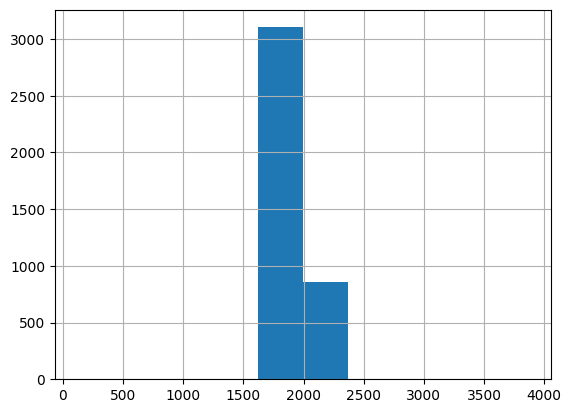

In [ ]:
# Check distribution
basal_energy_burned.basal_energy_burned.hist()

<AxesSubplot: xlabel='date', ylabel='basal_energy_burned'>

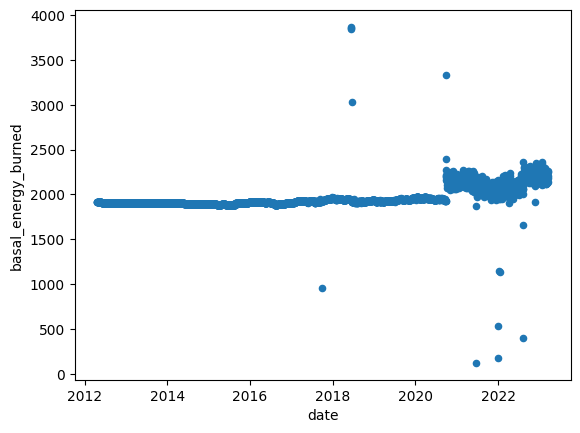

In [ ]:
basal_energy_burned.plot.scatter(x='date', y='basal_energy_burned')

Looks like Rob got a better tracker or became more serious about racking in 2021

# Body Mass

In [ ]:
body_mass.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Sync Solver,NaN,NaN,BodyMass,lb,2015-04-19 09:42:09 -0400,2014-07-01 00:00:00 -0400,2014-07-01 23:59:59 -0400,188.799
1,Sync Solver,NaN,NaN,BodyMass,lb,2015-04-19 09:42:09 -0400,2014-10-27 00:00:00 -0400,2014-10-27 23:59:59 -0400,188.799
2,Sync Solver,NaN,NaN,BodyMass,lb,2015-04-19 09:42:09 -0400,2012-09-21 00:00:00 -0400,2012-09-21 23:59:59 -0400,188.799
3,Sync Solver,NaN,NaN,BodyMass,lb,2015-04-19 09:42:09 -0400,2014-04-22 00:00:00 -0400,2014-04-22 23:59:59 -0400,188.799
4,Sync Solver,NaN,NaN,BodyMass,lb,2015-04-19 09:42:09 -0400,2013-06-27 00:00:00 -0400,2013-06-27 23:59:59 -0400,188.799


In [ ]:
body_mass["date"] = pd.to_datetime(body_mass["startDate"]).dt.date
body_mass = body_mass.groupby("date").sum().reset_index()
body_mass = body_mass.rename(columns={"value": "body_mass"})
body_mass = fix_double_tracking(body_mass, "body_mass")
body_mass.head()

/tmp/ipykernel_4203/4222922577.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  body_mass = body_mass.groupby("date").sum().reset_index()


,date,device,body_mass
0,2012-04-20,0.0,188.799
1,2012-04-21,0.0,188.799
2,2012-04-22,0.0,188.799
3,2012-04-23,0.0,188.799
4,2012-04-24,0.0,188.799


<AxesSubplot: >

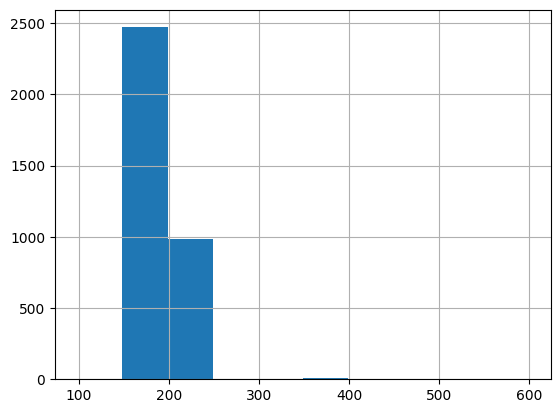

In [ ]:
# Check distribution
body_mass.body_mass.hist()

<AxesSubplot: xlabel='date', ylabel='body_mass'>

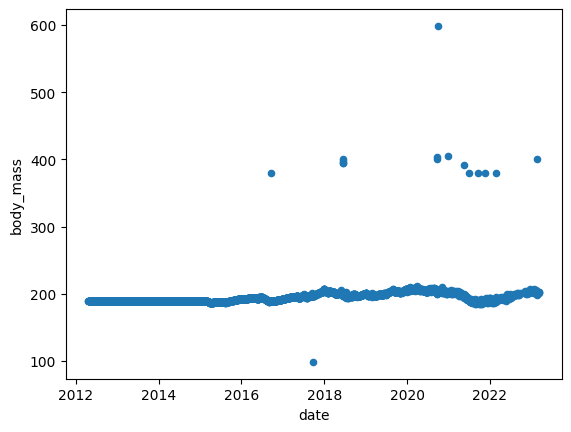

In [ ]:
body_mass.plot.scatter(x='date', y='body_mass')

## Flights Climbed

In [ ]:
flights_climbed.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28072cc80>, name:iPhone, manufac...",FlightsClimbed,count,2020-06-10 08:31:34 -0400,2020-06-10 08:20:49 -0400,2020-06-10 08:22:22 -0400,2
1,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28072cc80>, name:iPhone, manufac...",FlightsClimbed,count,2020-06-10 08:43:31 -0400,2020-06-10 08:32:09 -0400,2020-06-10 08:38:07 -0400,2
2,Rob’s iPhone,12.2,NaN,FlightsClimbed,count,2019-04-17 22:39:12 -0400,2019-04-17 22:27:09 -0400,2019-04-17 22:27:19 -0400,1
3,Rob’s iPhone,12.2,NaN,FlightsClimbed,count,2019-04-18 12:29:54 -0400,2019-04-18 12:19:48 -0400,2019-04-18 12:19:51 -0400,1
4,Rob’s iPhone,12.2,NaN,FlightsClimbed,count,2019-04-18 17:38:13 -0400,2019-04-18 17:26:56 -0400,2019-04-18 17:27:13 -0400,2


In [ ]:
flights_climbed["date"] = pd.to_datetime(flights_climbed["startDate"]).dt.date
flights_climbed = flights_climbed.groupby("date").sum().reset_index()
flights_climbed = flights_climbed.rename(columns={"value": "flights_climbed"})
flights_climbed = fix_double_tracking(flights_climbed, "flights_climbed")
flights_climbed.head()

/tmp/ipykernel_4203/502038652.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flights_climbed = flights_climbed.groupby("date").sum().reset_index()


,date,flights_climbed
0,2015-04-19,8.0
1,2015-04-20,9.0
2,2015-04-21,5.0
3,2015-04-22,15.0
4,2015-04-23,23.0


<AxesSubplot: >

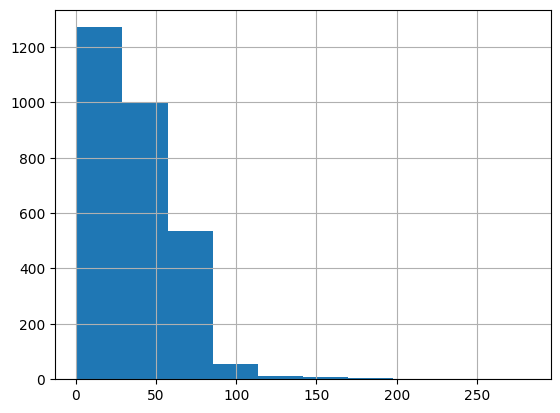

In [ ]:
# Check distribution
flights_climbed.flights_climbed.hist()

# Definitely lognormal

<AxesSubplot: xlabel='date', ylabel='flights_climbed'>

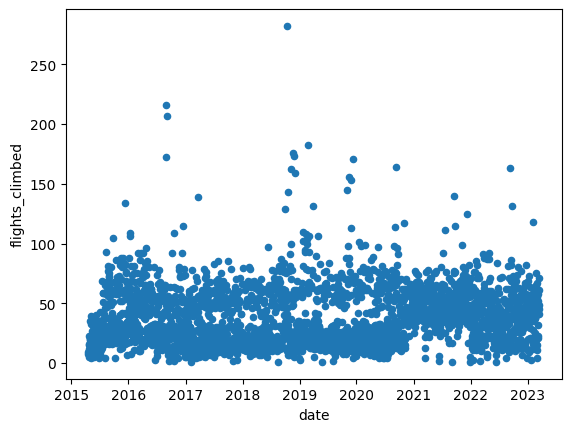

In [ ]:
flights_climbed.plot.scatter(x='date', y='flights_climbed')

Very weird data. Will have to explore further. Possible duplication?

## Step Count

In [ ]:
step_count.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28043ab20>, name:iPhone, manufac...",StepCount,count,2020-06-09 23:20:34 -0400,2020-06-09 21:44:08 -0400,2020-06-09 21:44:10 -0400,18
1,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28043ab20>, name:iPhone, manufac...",StepCount,count,2020-06-10 00:11:45 -0400,2020-06-10 00:00:42 -0400,2020-06-10 00:00:45 -0400,8
2,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28043ab20>, name:iPhone, manufac...",StepCount,count,2020-06-10 00:22:53 -0400,2020-06-10 00:11:50 -0400,2020-06-10 00:11:58 -0400,16
3,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28043ab20>, name:iPhone, manufac...",StepCount,count,2020-06-10 07:43:48 -0400,2020-06-10 07:29:09 -0400,2020-06-10 07:35:39 -0400,32
4,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28043ab20>, name:iPhone, manufac...",StepCount,count,2020-06-10 08:13:02 -0400,2020-06-10 08:02:00 -0400,2020-06-10 08:02:07 -0400,20


In [ ]:
step_count["date"] = pd.to_datetime(step_count["startDate"]).dt.date
step_count = step_count.groupby("date").sum().reset_index()
step_count = step_count.rename(columns={"value": "step_count"})
step_count = fix_double_tracking(step_count, "step_count")
step_count.head()

/tmp/ipykernel_4203/2595308794.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  step_count = step_count.groupby("date").sum().reset_index()


,date,step_count
0,2015-02-18,44.0
1,2015-02-19,2669.0
2,2015-02-20,14552.0
3,2015-02-21,7769.0
4,2015-02-22,16675.0


<AxesSubplot: >

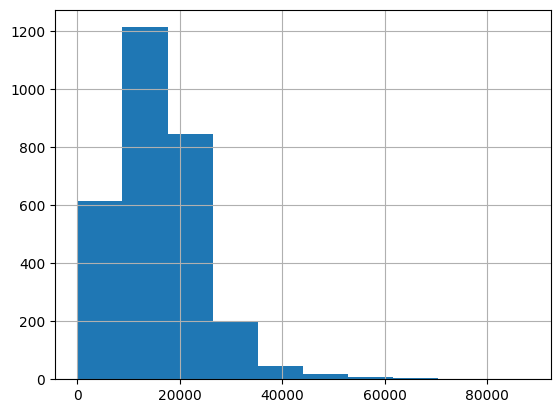

In [ ]:
# Check distribution
step_count.step_count.hist()

#kind of lognormal but not quite

<AxesSubplot: xlabel='date', ylabel='step_count'>

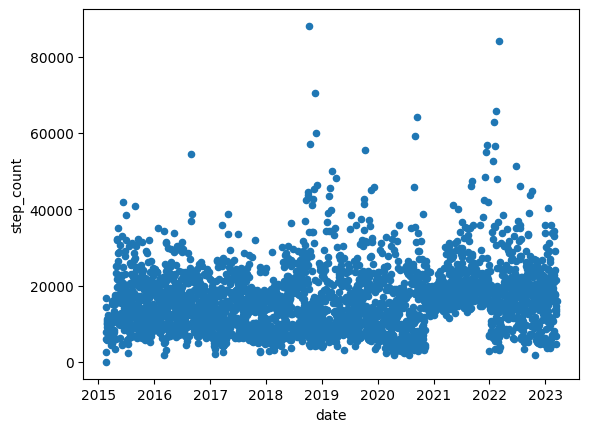

In [ ]:
step_count.plot.scatter(x='date', y='step_count')

## Body Mass Index
This is a slow changing variable


In [ ]:
body_mass_index.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Sync Solver,NaN,NaN,BodyMassIndex,count,2015-04-19 09:42:10 -0400,2015-01-17 01:00:00 -0400,2015-01-18 00:59:59 -0400,23.5981
1,Sync Solver,NaN,NaN,BodyMassIndex,count,2015-04-19 09:42:10 -0400,2013-08-18 00:00:00 -0400,2013-08-18 23:59:59 -0400,23.5981
2,Sync Solver,NaN,NaN,BodyMassIndex,count,2015-04-19 09:42:10 -0400,2013-05-19 00:00:00 -0400,2013-05-19 23:59:59 -0400,23.5981
3,Sync Solver,NaN,NaN,BodyMassIndex,count,2015-04-19 09:42:10 -0400,2013-04-25 00:00:00 -0400,2013-04-25 23:59:59 -0400,23.5981
4,Sync Solver,NaN,NaN,BodyMassIndex,count,2015-04-19 09:42:10 -0400,2013-10-11 00:00:00 -0400,2013-10-11 23:59:59 -0400,23.5981


In [ ]:
body_mass_index["date"] = pd.to_datetime(body_mass_index["startDate"]).dt.date
body_mass_index = body_mass_index.groupby("date").mean(numeric_only =True).reset_index() #! MEAN here
body_mass_index = body_mass_index.rename(columns={"value": "body_mass_index"})
body_mass_index = body_mass_index.drop(columns=["sourceVersion", "device"], axis=1)
body_mass_index.head()

,date,body_mass_index
0,2012-04-20,23.5981
1,2012-04-21,23.5981
2,2012-04-22,23.5981
3,2012-04-23,23.5981
4,2012-04-24,23.5981


<AxesSubplot: >

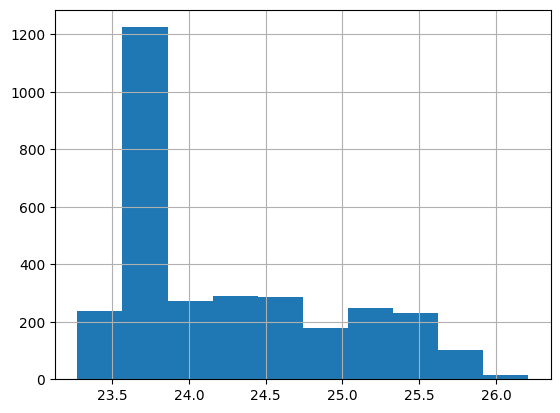

In [ ]:
# Check distribution
body_mass_index.body_mass_index.hist()

<AxesSubplot: xlabel='date', ylabel='body_mass_index'>

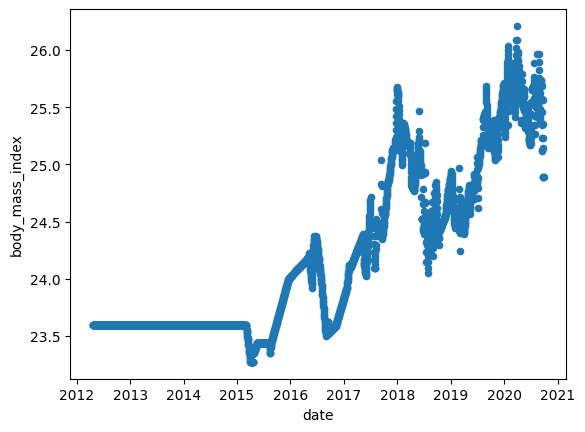

In [ ]:
body_mass_index.plot.scatter(x='date', y='body_mass_index')

Not measured frequently in 2012-2015

## Distance Walking/Running

In [ ]:
distance_walking_running.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28074afd0>, name:iPhone, manufac...",DistanceWalkingRunning,mi,2020-06-09 23:20:34 -0400,2020-06-09 21:44:08 -0400,2020-06-09 21:44:10 -0400,0.007941
1,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28074afd0>, name:iPhone, manufac...",DistanceWalkingRunning,mi,2020-06-10 00:11:45 -0400,2020-06-10 00:00:42 -0400,2020-06-10 00:00:45 -0400,0.002138
2,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28074afd0>, name:iPhone, manufac...",DistanceWalkingRunning,mi,2020-06-10 00:22:53 -0400,2020-06-10 00:11:50 -0400,2020-06-10 00:11:58 -0400,0.007214
3,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28074afd0>, name:iPhone, manufac...",DistanceWalkingRunning,mi,2020-06-10 07:43:48 -0400,2020-06-10 07:29:09 -0400,2020-06-10 07:35:39 -0400,0.012353
4,Rob’s iPhone,13.5.1,"<<HKDevice: 0x28074afd0>, name:iPhone, manufac...",DistanceWalkingRunning,mi,2020-06-10 08:13:02 -0400,2020-06-10 08:02:00 -0400,2020-06-10 08:02:07 -0400,0.007668


In [ ]:
distance_walking_running["date"] = pd.to_datetime(distance_walking_running["startDate"]).dt.date
distance_walking_running = distance_walking_running.groupby("date").sum().reset_index()
distance_walking_running = distance_walking_running.rename(columns={"value": "distance"})
distance_walking_running = fix_double_tracking(distance_walking_running, "distance")
distance_walking_running.head()

/tmp/ipykernel_4203/241688912.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  distance_walking_running = distance_walking_running.groupby("date").sum().reset_index()


,date,distance
0,2015-02-18,0.019188
1,2015-02-19,1.311870
2,2015-02-20,7.167910
3,2015-02-21,3.823910
4,2015-02-22,8.195990


<AxesSubplot: >

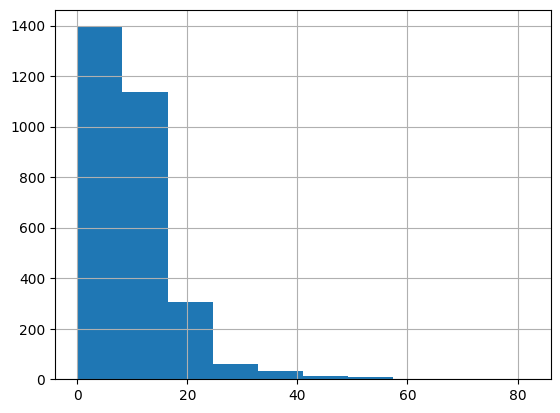

In [ ]:
# Check distribution
distance_walking_running.distance.hist()

# Lognormal

<AxesSubplot: xlabel='date', ylabel='distance'>

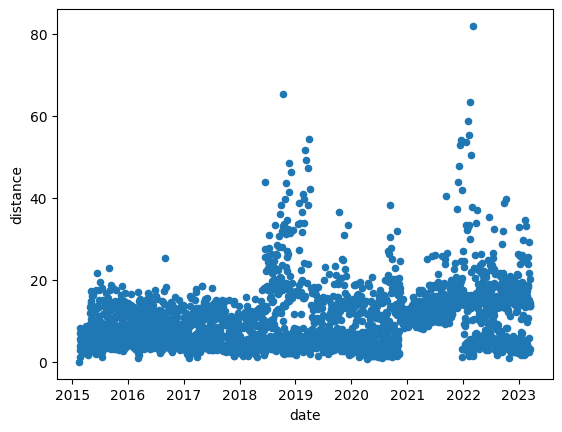

In [ ]:
distance_walking_running.plot.scatter(x='date', y='distance')

# Feature Engineering

In [ ]:
# Combine all data into one DataFrame

for d in [basal_energy_burned, body_mass, flights_climbed, step_count, body_mass_index, distance_walking_running]:
    df = df.merge(d, on="date", how="left")

# Time series data so use ffill
df = df.fillna(method="ffill")
# Note: also ffills sleep_hours 

df.head()

,date,sleep_hours,day_of_week,month,is_weekend,is_holiday,is_workday,basal_energy_burned,device,body_mass,flights_climbed,step_count,body_mass_index,distance
0,2015-02-19,6.400000,3,2,0,0,1,1898.0,0.0,188.799,NaN,2669.0,23.5981,1.31187
1,2015-02-20,7.583333,4,2,0,0,1,1898.0,0.0,188.799,NaN,14552.0,23.5981,7.16791
2,2015-02-21,6.350000,5,2,1,0,0,1898.0,0.0,188.799,NaN,7769.0,23.5981,3.82391
3,2015-02-22,6.500000,6,2,1,0,0,1898.0,0.0,188.799,NaN,16675.0,23.5981,8.19599
4,2015-02-23,8.916667,0,2,0,0,1,1898.0,0.0,188.799,NaN,6076.0,23.5981,2.98648


In [ ]:
# Interactions
df["distance_per_step"] = df["distance"] / df["step_count"] # To account for jumping, hiking, etc.
df["calorie_per_step"] = df["basal_energy_burned"] / df["step_count"] # To account for intensity of exercise
d["calorie_per_distance"] = df["basal_energy_burned"] / df["distance"] # Gym days vs. Outdoor days

df.head()

,date,sleep_hours,day_of_week,month,is_weekend,is_holiday,is_workday,basal_energy_burned,device,body_mass,flights_climbed,step_count,body_mass_index,distance,distance_per_step,calorie_per_step
0,2015-02-19,6.400000,3,2,0,0,1,1898.0,0.0,188.799,NaN,2669.0,23.5981,1.31187,0.000492,0.711128
1,2015-02-20,7.583333,4,2,0,0,1,1898.0,0.0,188.799,NaN,14552.0,23.5981,7.16791,0.000493,0.130429
2,2015-02-21,6.350000,5,2,1,0,0,1898.0,0.0,188.799,NaN,7769.0,23.5981,3.82391,0.000492,0.244304
3,2015-02-22,6.500000,6,2,1,0,0,1898.0,0.0,188.799,NaN,16675.0,23.5981,8.19599,0.000492,0.113823
4,2015-02-23,8.916667,0,2,0,0,1,1898.0,0.0,188.799,NaN,6076.0,23.5981,2.98648,0.000492,0.312377


In [ ]:
# Time series predictions to come later
# Try a column for every sleep_hours for the past week

# Prophet by META
Testing a simple prophet model

In [ ]:
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

df_p = df[['date', 'sleep_hours']].copy()

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
for (train_index, test_index) in tscv.split(df_p):
    train = df_p.iloc[train_index]
    test = df_p.iloc[test_index]
    
    train = train.rename(columns={'date': 'ds', 'sleep_hours': 'y'})
    test = test.rename(columns={'date': 'ds', 'sleep_hours': 'y'})
    
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=len(test), freq='D') # Ensure the frequency is set to daily
    forecast = m.predict(future)

    test['yhat'] = forecast['yhat'].values[-len(test):]
    test['yhat_lower'] = forecast['yhat_lower'].values[-len(test):]
    test['yhat_upper'] = forecast['yhat_upper'].values[-len(test):]
    
    df_p.iloc[test_index] = test

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test['y'], test['yhat'])) # Use mean_squared_error from sklearn
    rmse_scores.append(rmse)

print(f"Mean RMSE: {np.mean(rmse_scores)}")

16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing


Mean RMSE: 1.1050179696209157


In [ ]:
# Fit Final Model
m = Prophet()
m.fit(df_p.rename(columns={'date': 'ds', 'sleep_hours': 'y'}))

sub_prophet = sub.copy()
forecast = m.predict(sub_prophet.rename(columns={'date': 'ds'}))
sub_prophet['sleep_hours'] = forecast['yhat']
sub_median.to_csv("./submissions/submission_prophet.csv", index=False)
sub_median.head()

# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_prophet.csv -m "Trying Prophet"
# Score: __________________

16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing


,date,sleep_hours
0,2022-01-01,6.683333
1,2022-01-02,6.683333
2,2022-01-03,6.683333
3,2022-01-04,6.683333
4,2022-01-05,6.683333


In [28]:
from helper import *

df, f_transformer, t_transformer, cols = create_data("./data/train.csv", type="train")


df.head()

2023-03-21 22:08:09,287 - INFO - Reading train data from ./data/train.csv
2023-03-21 22:08:09,292 - INFO - Start date: 2015-02-19
2023-03-21 22:08:09,292 - INFO - End date: 2021-12-31
2023-03-21 22:08:09,295 - INFO - missing days: 154
2023-03-21 22:08:09,295 - INFO - Featurizing time series data
2023-03-21 22:08:09,324 - INFO - Featurizing XML data
2023-03-21 22:08:14,372 - INFO - Imputing missing values...
2023-03-21 22:08:14,374 - INFO - Creating interactions...
2023-03-21 22:08:14,375 - INFO - Saving to Parquet file...


,date,sleep_hours,day_of_week,day_of_year,month,month_sin,is_weekend,is_holiday,is_workday,is_daylight_savings,...,DistanceWalkingRunning_mn_st_hr_cos,DistanceWalkingRunning_mx_et_hr_sin,DistanceWalkingRunning_mx_et_hr_cos,DistanceWalkingRunning_mn_et_hr_sin,DistanceWalkingRunning_mn_et_hr_cos,DistanceWalkingRunning_hours_between,dow_median,distance_per_step,calorie_per_step,calorie_per_distance
0,2015-02-19,6.400000,3,50,2,0.866025,0,0,1,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.716667,0.000492,0.711128,1446.789697
1,2015-02-20,7.583333,4,51,2,0.866025,0,0,1,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.766667,0.000493,0.130429,264.791271
2,2015-02-21,6.350000,5,52,2,0.866025,1,0,0,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.950000,0.000492,0.244304,496.350594
3,2015-02-22,6.500000,6,53,2,0.866025,1,0,0,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.808333,0.000492,0.113823,231.576661
4,2015-02-23,8.916667,0,54,2,0.866025,0,0,1,0,...,1.0,-0.258819,0.965926,-0.258819,0.965926,24.0,6.533333,0.000492,0.312377,635.530792


In [29]:
#df = df.drop(columns=["date"])
df.to_csv("./train_clean.csv", index=False)

In [30]:
df.FlightsClimbed_mx_st_hr_sin.value_counts()

-2.588190e-01    818
-5.000000e-01    503
-7.071068e-01    423
-8.660254e-01    301
-9.659258e-01    148
-1.000000e+00     87
-9.659258e-01     55
 0.000000e+00     35
-8.660254e-01     25
-7.071068e-01     10
-5.000000e-01      9
-2.588190e-01      9
 1.224647e-16      8
 7.071068e-01      6
 2.588190e-01      4
 5.000000e-01      4
 8.660254e-01      2
 2.588190e-01      2
Name: FlightsClimbed_mx_st_hr_sin, dtype: int64

In [33]:
df

,date,sleep_hours,day_of_week,day_of_year,month,month_sin,is_weekend,is_holiday,is_workday,is_daylight_savings,...,DistanceWalkingRunning_mn_st_hr_cos,DistanceWalkingRunning_mx_et_hr_sin,DistanceWalkingRunning_mx_et_hr_cos,DistanceWalkingRunning_mn_et_hr_sin,DistanceWalkingRunning_mn_et_hr_cos,DistanceWalkingRunning_hours_between,dow_median,distance_per_step,calorie_per_step,calorie_per_distance
0,2015-02-19,6.400000,3,50,2,8.660254e-01,0,0,1,0,...,1.000000,-0.258819,0.965926,-0.258819,0.965926,24.000000,6.716667,0.000492,0.711128,1446.789697
1,2015-02-20,7.583333,4,51,2,8.660254e-01,0,0,1,0,...,1.000000,-0.258819,0.965926,-0.258819,0.965926,24.000000,6.766667,0.000493,0.130429,264.791271
2,2015-02-21,6.350000,5,52,2,8.660254e-01,1,0,0,0,...,1.000000,-0.258819,0.965926,-0.258819,0.965926,24.000000,6.950000,0.000492,0.244304,496.350594
3,2015-02-22,6.500000,6,53,2,8.660254e-01,1,0,0,0,...,1.000000,-0.258819,0.965926,-0.258819,0.965926,24.000000,6.808333,0.000492,0.113823,231.576661
4,2015-02-23,8.916667,0,54,2,8.660254e-01,0,0,1,0,...,1.000000,-0.258819,0.965926,-0.258819,0.965926,24.000000,6.533333,0.000492,0.312377,635.530792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,2021-12-27,3.850000,0,361,12,-2.449294e-16,0,0,1,0,...,1.000000,-0.707107,0.707107,0.258819,0.965926,3.550278,6.533333,0.000472,0.321293,680.370273
2504,2021-12-28,3.850000,1,362,12,-2.449294e-16,0,0,1,0,...,0.965926,-0.707107,0.707107,0.258819,0.965926,11.613333,6.541667,0.000435,0.157581,362.446131
2505,2021-12-29,6.175000,2,363,12,-2.449294e-16,0,0,1,0,...,-0.500000,-0.258819,0.965926,0.866025,-0.500000,0.300278,6.566667,0.000437,0.035070,80.165201
2506,2021-12-30,5.158333,3,364,12,-2.449294e-16,0,0,1,0,...,1.000000,-0.258819,0.965926,0.000000,1.000000,0.666944,6.716667,0.000945,0.133693,141.511356


{'name': 'lstm_sweep', 'program': 'lstm_sweep.py', 'method': 'bayes', 'metric': {'name': 'Validation Loss', 'goal': 'minimize'}, 'parameters': {'learning_rate': {'min': 0.0001, 'max': 0.01}, 'dropout_prob': {'min': 0.0, 'max': 0.5}, 'batch_size': {'values': [8, 32, 64]}, 'input_size': {'values': [1, 2, 3]}, 'hidden_size': {'values': [16, 32, 64, 128]}, 'num_layers': {'values': [2, 3]}, 'lookback': {'values': [3, 5, 7, 14]}}}
